# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the necessary libraries

In [66]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input as pi_mobnet
from tensorflow.keras.applications.mobilenet import MobileNet
from PIL import Image
from tensorflow.keras import *
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

### Change directory

In [3]:
os.chdir('/content/drive/MyDrive/ACV')

### Load the training data from train.csv file

In [4]:
train_df = pd.read_csv('train_labels.csv')

In [6]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [5]:
train_df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [7]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [8]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [21]:
os.chdir('/content/drive/My Drive/ACV/images')

In [49]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = pi_mobnet(np.array(img, dtype=np.float32))

In [ ]:
batch_images

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [107]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0, weights="imagenet")
for layer in model.layers:
        layer.trainable = False

mob_out = model.layers[-1].output
conv1 = Conv2D(4, kernel_size=4, name="coords")(mob_out)
reshape1 = Reshape((4,))(conv1) # These are the 4 predicted coordinates of one BBox
model = Model(inputs=model.input, outputs=reshape1)

In [108]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

### Define a custom loss function IoU which calculates Intersection Over Union

In [109]:
import tensorflow
from tensorflow.keras.backend import epsilon

In [110]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tensorflow.compat.v1.py_func(loss, [y_true, y_pred], tensorflow.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [111]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'mse', metrics = IoU)

In [112]:
model.fit(x = batch_images, y = coords, epochs = 30, batch_size=32, verbose = 1)

Epoch 1/30
6/6 [==============================] - 4s 374ms/step - loss: 4813.7979 - IoU: 0.0674
Epoch 2/30
6/6 [==============================] - 2s 348ms/step - loss: 927.1005 - IoU: 0.3731
Epoch 3/30
6/6 [==============================] - 2s 344ms/step - loss: 448.3488 - IoU: 0.5671
Epoch 4/30
6/6 [==============================] - 2s 325ms/step - loss: 635.3374 - IoU: 0.5369
Epoch 5/30
6/6 [==============================] - 2s 351ms/step - loss: 386.1260 - IoU: 0.5949
Epoch 6/30
6/6 [==============================] - 2s 350ms/step - loss: 190.4812 - IoU: 0.6649
Epoch 7/30
6/6 [==============================] - 2s 329ms/step - loss: 175.0002 - IoU: 0.6700
Epoch 8/30
6/6 [==============================] - 2s 333ms/step - loss: 158.8590 - IoU: 0.6904
Epoch 9/30
6/6 [==============================] - 2s 328ms/step - loss: 119.3156 - IoU: 0.7512
Epoch 10/30
6/6 [==============================] - 2s 333ms/step - loss: 105.7774 - IoU: 0.7758
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [155]:
import cv2

In [206]:
#Taking racoon 105 or 106
unscaled = cv2.imread('raccoon-10.jpg') # Read image 

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [207]:
unscaled = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
unscaled = pi_mobnet(np.array(unscaled, dtype=np.float32))

In [208]:
unscaled.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


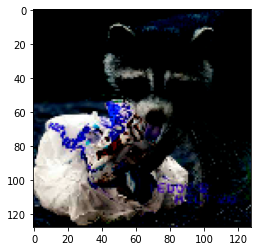

In [209]:
plt.imshow(unscaled)

### Predict the coordinates of the bounding box for the given test image

In [210]:
image_height, image_width, _ = unscaled.shape
region = model.predict(x=np.array([unscaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


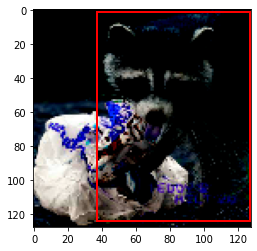

In [211]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()